**Task:**
Extract region proposals for all the images and annotate each Region of Interest (ROI) with
* Class that it belongs to
* Offset from the ground truth bounding box
* IOU of the ROI with the ground truth bounding box

In [1]:
from src.core import *
from collections import Counter
from tqdm.notebook import tqdm; tqdm.pandas()
import cv2

import torch
from torchvision.io import read_image, ImageReadMode
from torchvision.ops import box_iou

In [2]:
df, id2label, id2img = load_data(ann_file='data/train.json', imgs_folder='data/train')

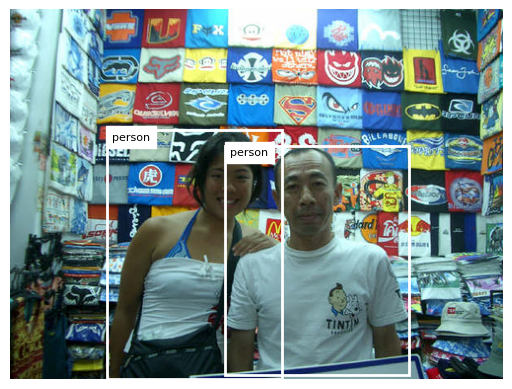

In [3]:
img_id, gtbbs, cat_ids = df.loc[90, ['image_id','bbox','category_id']]
img_path = id2img[img_id]

show_bbs(img_path, gtbbs, [id2label[id] for id in cat_ids])

In [4]:
img = read_image(img_path, mode=ImageReadMode.RGB)
gtbbs, cat_ids = torch.tensor(gtbbs), torch.tensor(cat_ids)

In [37]:
def extract_rois(img, min_size=0.05):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img.permute(1, 2, 0).numpy())
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    h,w = img.shape[1:]; img_area = h*w
    sizes = rects[:,2]*rects[:,3]    
    mask = (sizes>min_size*img_area) & (sizes<img_area)
    rects = rects[mask]
    
    return torch.tensor(rects, dtype=torch.float32)

In [38]:
rois = extract_rois(img)
print(rois.shape, gtbbs.shape)

torch.Size([648, 4]) torch.Size([2, 4])


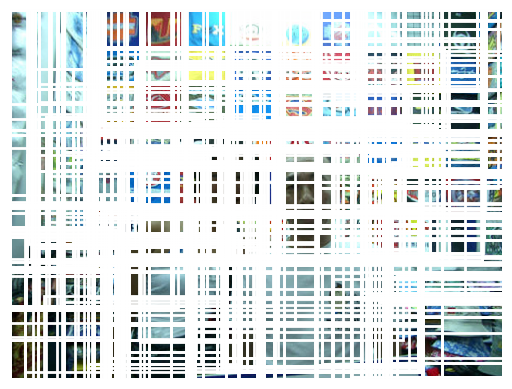

In [39]:
show_bbs(img_path, rois)

In [43]:
r_xyXY = torch.cat([rois[:,:2], rois[:,:2]+rois[:,2:]-1], dim=1)
gt_xyXY = torch.cat([gtbbs[:,:2], gtbbs[:,:2]+gtbbs[:,2:]-1], dim=1)
ious = box_iou(r_xyXY, gt_xyXY)
max_ious, max_idxs = ious.max(dim=1)
valid_mask = max_ious>0.5

ious.shape, torch.sum(valid_mask)

(torch.Size([648, 2]), tensor(50))

In [44]:
def calculate_offsets(rois, gtbbs):
    # Convert to center coordinates
    roi_centers = rois[:, :2] + rois[:, 2:]/2
    gt_centers = gtbbs[:, :2] + gtbbs[:, 2:]/2
    
    # Calculate offsets with numerical stability
    epsilon = 1e-8
    roi_widths = rois[:, 2] + epsilon
    roi_heights = rois[:, 3] + epsilon
    
    dx = (gt_centers[:, 0] - roi_centers[:, 0]) / roi_widths
    dy = (gt_centers[:, 1] - roi_centers[:, 1]) / roi_heights
    dw = torch.log(gtbbs[:, 2] / roi_widths)
    dh = torch.log(gtbbs[:, 3] / roi_heights)
    
    return torch.stack([dx, dy, dw, dh], dim=1)

In [46]:
def annotate_rois(rois, gtbbs, cat_ids, cat_thresh=0.5):
    r_xyXY = torch.cat([rois[:,:2], rois[:,:2]+rois[:,2:]-1], dim=1)
    gt_xyXY = torch.cat([gtbbs[:,:2], gtbbs[:,:2]+gtbbs[:,2:]-1], dim=1)
    ious = box_iou(r_xyXY, gt_xyXY)
    max_ious, max_idxs = ious.max(dim=1)
    
    valid_mask = max_ious>cat_thresh
    roi_ids = torch.full((rois.shape[0],), 0, dtype=torch.long)
    roi_ids[valid_mask] = cat_ids[max_idxs[valid_mask]]
    offsets = calculate_offsets(rois, gtbbs[max_idxs])
    return roi_ids, offsets, max_ious

In [47]:
roi_ids, offsets, max_ious = annotate_rois(rois, gtbbs, cat_ids)

roi_ids.shape, offsets.shape, max_ious.shape

(torch.Size([648]), torch.Size([648, 4]), torch.Size([648]))

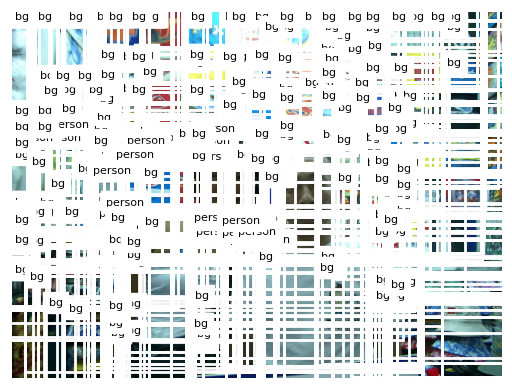

In [49]:
labels = [id2label[id.item()] if id!=0 else 'bg' for id in roi_ids]
show_bbs(img_path, rois, labels)

In [50]:
def get_annotated_rois(row, min_size=0.05, cat_thresh=0.5):
    img_id, gtbbs, cat_ids = row[['image_id','bbox','category_id']]
    img = read_image(id2img[img_id], mode=ImageReadMode.RGB)
    gtbbs = torch.tensor(gtbbs, dtype=torch.float32)
    cat_ids = torch.tensor(cat_ids, dtype=torch.long)

    rois = extract_rois(img, min_size=min_size)
    roi_ids, offsets, _ = annotate_rois(rois, gtbbs, cat_ids, cat_thresh)
    data = {k:locals()[k].tolist() for k in ['rois','roi_ids','offsets']}
    data['image_id'] = img_id
    return pd.Series(data)

In [65]:
n = 50
roi_df = df.loc[:n].progress_apply(get_annotated_rois, axis=1, args=(0.05, 0.5))

  0%|          | 0/51 [00:00<?, ?it/s]

In [66]:
def calc_recall(row, gt_df):
    cat_ids = gt_df.loc[row['image_id'], 'category_id']
    cat_freqs = Counter(cat_ids)
    roi_ids = row['roi_ids']
    roi_freqs = Counter(roi_ids)

    total_gt = len(cat_ids)
    matched_gt = sum(min(freq, roi_freqs[id]) for id, freq in cat_freqs.items())
    recall = matched_gt/total_gt
    return pd.Series({k:locals()[k] for k in ['total_gt','matched_gt','recall']})

recall_df = roi_df.progress_apply(calc_recall, axis=1, gt_df=df.set_index('image_id'))

  0%|          | 0/51 [00:00<?, ?it/s]

In [67]:
print(f'Overall recall: {recall_df.matched_gt.sum()/recall_df.total_gt.sum()}')

recall_df.describe()

Overall recall: 0.8532110091743119


,total_gt,matched_gt,recall
count,51.000000,51.000000,51.000000
mean,2.137255,1.823529,0.835574
std,1.865686,1.829818,0.342589
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,3.000000,2.000000,1.000000
max,11.000000,11.000000,1.000000


In [68]:
roi_df = df.loc[:n].progress_apply(get_annotated_rois, axis=1, args=(0.01, 0.5))

recall_df = roi_df.progress_apply(calc_recall, axis=1, gt_df=df.set_index('image_id'))
print(f'Overall recall: {recall_df.matched_gt.sum()/recall_df.total_gt.sum()}')

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Overall recall: 0.9541284403669725


In [76]:
def create_roi_file(res_file, gt_file, imgs_folder='data/train'):
    # read ground truth file
    df, id2label, id2img = load_data(ann_file=gt_file, imgs_folder=imgs_folder)
    # extract and annotate rois
    roi_df = df.progress_apply(get_annotated_rois, axis=1, args=(0.01, 0.5))
    # calculate the overall recall of the extraction
    recall_df = roi_df.progress_apply(calc_recall, axis=1, gt_df=df.set_index('image_id'))
    print(f'Overall recall: {recall_df.matched_gt.sum()/recall_df.total_gt.sum()}')
    # write to file
    (roi_df
     .explode(roi_df.columns.drop('image_id').tolist())
     .to_json(res_file, orient='records')
    )

In [77]:
create_roi_file('tmp/train_rois.json', 'tmp/train.json')
create_roi_file('tmp/valid_rois.json', 'tmp/valid.json')

  0%|          | 0/4573 [00:00<?, ?it/s]

  0%|          | 0/4573 [00:00<?, ?it/s]

Overall recall: 0.9412906804733728


  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

Overall recall: 0.9437880415324025
